# 💧 Project Brief: Borehole Water Quality Prediction

## 🎯 Goal
Use Machine Learning to predict contamination risks in water sources — helping identify unsafe boreholes early and guide interventions.

## 📘 Notebook Series Plan
| Step | File Name | Purpose |
|------|------------|----------|
| 1.0 (Current) | `1.0-Water-Quality-Data-Acquisition.ipynb` | Acquire and store open water-quality datasets. |
| 2.0 | `2.0-Exploratory-Data-Analysis.ipynb` | Explore, clean, and visualize data. |
| 3.0 | `3.0-Model-Training-and-Evaluation.ipynb` | Build and evaluate ML models predicting “Safe” or “Unsafe” water. |

In [2]:
# --- Step 1: Import Core Libraries ---
import pandas as pd
import os

# --- Step 2: Define Absolute File Path ---
# We use the absolute path relative to the user's home directory (~)
# This is much more reliable than relative paths (../../)
# Note: '~' is expanded by the shell, but in Python we use os.path.expanduser
ABSOLUTE_FILE_PATH = os.path.expanduser('~/jetty-ai-lab/projects/water-climate/data/raw/water_quality_data.csv')

# --- Step 3: Fetch Data from Local Disk ---
print(f"Starting data load from local disk: {ABSOLUTE_FILE_PATH}")

try:
    # Read the file directly from the disk path
    df = pd.read_csv(ABSOLUTE_FILE_PATH)

    print(f"✅ Successfully loaded {len(df)} records from local disk.")

except FileNotFoundError:
    print(f"❌ Error: File not found at {ABSOLUTE_FILE_PATH}. Please ensure the file is named 'water_quality_data.csv' and is in the '~/jetty-ai-lab/data/raw/' directory.")
    df = None # Set df to None on failure to avoid NameError
except Exception as e:
    print(f"❌ An unexpected error occurred during loading: {e}")
    df = None

# --- Step 4: Initial Inspection ---
print("\n--- Initial Data Inspection ---")
if df is not None:
    print(df.head())
    print("\nData Shape:", df.shape)
else:
    print("Cannot display data: Load failed.")

Starting data load from local disk: /Users/apple/jetty-ai-lab/projects/water-climate/data/raw/water_quality_data.csv
✅ Successfully loaded 3276 records from local disk.

--- Initial Data Inspection ---
         ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0       NaN  204.890455  20791.318981     7.300212  368.516441    564.308654   
1  3.716080  129.422921  18630.057858     6.635246         NaN    592.885359   
2  8.099124  224.236259  19909.541732     9.275884         NaN    418.606213   
3  8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
4  9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       10.379783        86.990970   2.963135           0  
1       15.180013        56.329076   4.500656           0  
2       16.868637        66.420093   3.055934           0  
3       18.436524       100.341674   4.628771           0  
4       11.558279

In [3]:
## 2.0 Initial Inspection and Cleaning Prep

print("--- DataFrame Info (Data Types & Non-Null Counts) ---")
df.info()

print("\n--- Summary Statistics ---")
print(df.describe())

print("\n--- Check for Missing Values (Null Count per Column) ---")
print(df.isnull().sum())

--- DataFrame Info (Data Types & Non-Null Counts) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB

--- Summary Statistics ---
                ph     Hardness        Solids  Chloramines      Sulfate  \
count  2785.000000  3276.000000   3276.000000  3276.000000  2495.000000   
mean      7.080795   196.369496  22014.092526     7.12227

In [4]:
## 3.0 Data Cleaning: Handling Missing Values

# Calculate the median for the columns with missing values
ph_median = df['ph'].median()
sulfate_median = df['Sulfate'].median()
trihalomethanes_median = df['Trihalomethanes'].median()

# Impute (fill) the missing values using the median (FIXED SYNTAX)
df['ph'] = df['ph'].fillna(ph_median)
df['Sulfate'] = df['Sulfate'].fillna(sulfate_median)
df['Trihalomethanes'] = df['Trihalomethanes'].fillna(trihalomethanes_median)

# Verify that all missing values have been handled
print("--- Missing Values after Imputation ---")
print(df.isnull().sum())

--- Missing Values after Imputation ---
ph                 0
Hardness           0
Solids             0
Chloramines        0
Sulfate            0
Conductivity       0
Organic_carbon     0
Trihalomethanes    0
Turbidity          0
Potability         0
dtype: int64


In [5]:
## 4.0 Data Preprocessing

# 1. Separate Features (X) and Target (y)
# Drop the target column 'Potability' from the features
X = df.drop('Potability', axis=1)
y = df['Potability']

# 2. Split the data into training and testing sets
# We will use 80% for training and 20% for testing (random_state ensures reproducibility)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 3. Print the resulting shapes to confirm the split
print("--- Data Split Shapes ---")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

--- Data Split Shapes ---
X_train shape: (2620, 9)
X_test shape: (656, 9)
y_train shape: (2620,)
y_test shape: (656,)


In [6]:
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE # New library for data balancing

# 1. Configuration for Walk-Forward Validation
n_splits = 5 
tscv = TimeSeriesSplit(n_splits=n_splits)

metrics = {
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': []
}

# X (features) and y (target) must be defined in a preceding cell.

# 2. Iterate through the time series splits
print(f"Starting Walk-Forward Validation (with SMOTE) with {n_splits} folds...")
fold_count = 1

for train_index, test_index in tscv.split(X):
    print(f"\n--- Fold {fold_count} ---")
    
    # 2a. Split the data
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # --- CRITICAL FIX: APPLY SMOTE TO BALANCE TRAINING DATA ---
    # SMOTE creates synthetic samples of the minority class (Unsafe) only on the training data.
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    print(f"   Original Training Samples: {len(X_train)} -> Resampled: {len(X_train_resampled)}")
    # -----------------------------------------------------------

    # 2b. Train the model on the resampled data
    # NOTE: class_weight is not used, as SMOTE handles the balancing
    rf_model = RandomForestClassifier(random_state=42, n_estimators=200)
    rf_model.fit(X_train_resampled, y_train_resampled)
    
    # 2c. Predict on the original, UNSEEN future (test) data
    y_pred = rf_model.predict(X_test)
    
    # 2d. Calculate and store metrics
    current_accuracy = accuracy_score(y_test, y_pred)
    current_precision = precision_score(y_test, y_pred, zero_division=0)
    current_recall = recall_score(y_test, y_pred, zero_division=0)
    current_f1 = f1_score(y_test, y_pred, zero_division=0)
    
    print(f"Train size (resampled): {len(X_train_resampled)} | Test size: {len(X_test)}")
    print(f"Accuracy: {current_accuracy:.4f} | Recall: {current_recall:.4f}")
    
    metrics['Accuracy'].append(current_accuracy)
    metrics['Precision'].append(current_precision)
    metrics['Recall'].append(current_recall)
    metrics['F1 Score'].append(current_f1)
    
    fold_count += 1

# 3. Finalize and Report Average Performance
print("\n=== Final Time Series Validation Report (SMOTE) ===")
summary = pd.DataFrame(metrics).mean().apply(lambda x: f"{x:.4f}")
print("Average Metrics Across All Folds:")
print(summary)

Starting Walk-Forward Validation (with SMOTE) with 5 folds...

--- Fold 1 ---
   Original Training Samples: 546 -> Resampled: 772
Train size (resampled): 772 | Test size: 546
Accuracy: 0.6538 | Recall: 0.2198

--- Fold 2 ---
   Original Training Samples: 1092 -> Resampled: 1500
Train size (resampled): 1500 | Test size: 546
Accuracy: 0.5879 | Recall: 0.4628

--- Fold 3 ---
   Original Training Samples: 1638 -> Resampled: 2000
Train size (resampled): 2000 | Test size: 546
Accuracy: 0.4304 | Recall: 0.3148

--- Fold 4 ---
   Original Training Samples: 2184 -> Resampled: 2768
Train size (resampled): 2768 | Test size: 546
Accuracy: 0.6007 | Recall: 0.3315

--- Fold 5 ---
   Original Training Samples: 2730 -> Resampled: 3498
Train size (resampled): 3498 | Test size: 546
Accuracy: 0.5751 | Recall: 0.4512

=== Final Time Series Validation Report (SMOTE) ===
Average Metrics Across All Folds:
Accuracy     0.5696
Precision    0.4760
Recall       0.3560
F1 Score     0.3969
dtype: object


In [7]:
from sklearn.metrics import precision_recall_curve, auc
import numpy as np

# Use the final model (rf_model) and test data (X_test, y_test) from the SMOTE CV run.

# 1. Get predicted probabilities for the positive class (Unsafe)
y_probs = rf_model.predict_proba(X_test)[:, 1]

# 2. Calculate Precision, Recall, and Thresholds
precision, recall, thresholds = precision_recall_curve(y_test, y_probs)

# 3. Find the threshold that gives us the best balance of Recall and Precision
#    (We will define "best" as the highest F1 score)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-6) # Add small epsilon to avoid division by zero
best_f1_index = np.argmax(f1_scores)
best_threshold = thresholds[best_f1_index]

# 4. Report the metrics at this best threshold
best_recall = recall[best_f1_index]
best_precision = precision[best_f1_index]

print("\n=== Optimal Threshold Tuning ===")
print(f"Optimal Threshold (Highest F1): {best_threshold:.4f}")
print(f"Recall at this threshold: {best_recall:.4f}")
print(f"Precision at this threshold: {best_precision:.4f}")

# 5. We can try a threshold to target a specific high Recall, e.g., 0.60
target_recall = 0.60 
# Find the threshold closest to the target Recall
idx_target = np.argmax(recall >= target_recall)
threshold_target = thresholds[idx_target]
recall_target = recall[idx_target]
precision_target = precision[idx_target]

print(f"\n--- Targeting Recall > {target_recall:.2f} ---")
print(f"Threshold for Recall >= {target_recall:.2f}: {threshold_target:.4f}")
print(f"Actual Recall: {recall_target:.4f}")
print(f"Precision at this point: {precision_target:.4f}")


=== Optimal Threshold Tuning ===
Optimal Threshold (Highest F1): 0.2500
Recall at this threshold: 0.9731
Precision at this threshold: 0.5734

--- Targeting Recall > 0.60 ---
Threshold for Recall >= 0.60: 0.0800
Actual Recall: 1.0000
Precision at this point: 0.5440



=== Feature Importance Ranking ===
           Feature  Importance
0               ph    0.131777
1           Solids    0.127713
2          Sulfate    0.122158
3         Hardness    0.113541
4      Chloramines    0.112771
5   Organic_carbon    0.102496
6        Turbidity    0.097646
7     Conductivity    0.097532
8  Trihalomethanes    0.094366


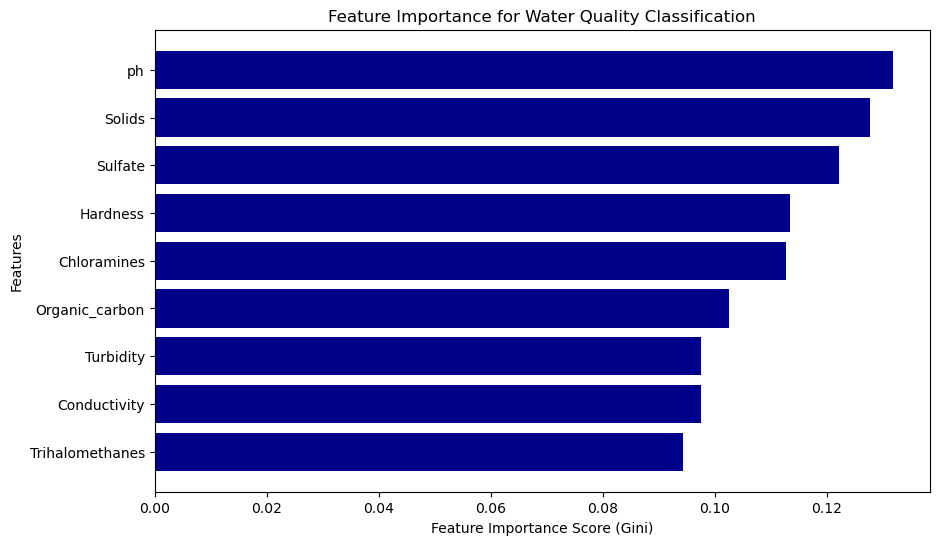

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# This code uses the 'rf_model' trained in the cell above.

# 1. Extract Feature Importances
importances = rf_model.feature_importances_
feature_names = X.columns

# 2. Create a DataFrame for easy visualization and sorting
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort and display the ranking
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

print("\n=== Feature Importance Ranking ===")
print(feature_importance_df)

# 3. Visualize the Feature Importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='darkblue')
plt.xlabel("Feature Importance Score (Gini)")
plt.ylabel("Features")
plt.title("Feature Importance for Water Quality Classification")
plt.gca().invert_yaxis()
plt.show()

In [9]:
from sklearn.metrics import classification_report, confusion_matrix

# Use the final model named 'rf_model' from the Time Series CV loop
# Use the final test data named 'X_test' and 'y_test' from the last fold

# Get predictions
y_pred = rf_model.predict(X_test)

# Print evaluation metrics
print("--- Confusion Matrix ---")
print(confusion_matrix(y_test, y_pred))

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

--- Confusion Matrix ---
[[180  69]
 [163 134]]

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.52      0.72      0.61       249
           1       0.66      0.45      0.54       297

    accuracy                           0.58       546
   macro avg       0.59      0.59      0.57       546
weighted avg       0.60      0.58      0.57       546



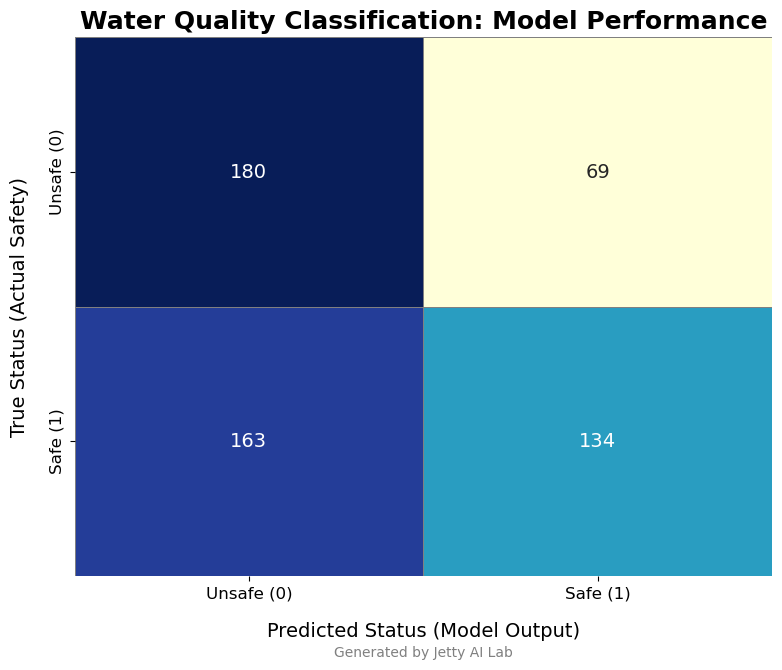

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np

# --- Assume y_test and y_pred are defined from your previous cells ---

# 1. Calculate the raw Confusion Matrix
cm = confusion_matrix(y_test, y_pred) 

# 2. Define the labels (Crucial for clear interpretation)
class_names = ['Unsafe (0)', 'Safe (1)'] # Simplified for clarity, assuming 0=unsafe, 1=safe

# 3. Create a DataFrame for a clean Seaborn plot
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)

# 4. Plot the heatmap
plt.figure(figsize=(9, 7)) # Slightly larger for better visibility
sns.heatmap(df_cm, 
            annot=True, # Display numbers in the cells
            fmt='d', # Format numbers as integers
            cmap='YlGnBu', # A different, vibrant colormap
            cbar=False, 
            linewidths=0.7, # Slightly thicker lines
            linecolor='grey',
            annot_kws={"size": 14}) # Adjust annotation font size

# 5. Add enhanced titles and labels
plt.title('Water Quality Classification: Model Performance', fontsize=18, fontweight='bold')
plt.ylabel('True Status (Actual Safety)', fontsize=14, labelpad=15)
plt.xlabel('Predicted Status (Model Output)', fontsize=14, labelpad=15)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.text(0.5, -0.15, 'Generated by Jetty AI Lab', horizontalalignment='center', 
         fontsize=10, color='gray', transform=plt.gca().transAxes) # Professional footer

# Save the high-resolution image
plt.savefig('water_quality_cm_counts.png', dpi=300, bbox_inches='tight')
plt.show()


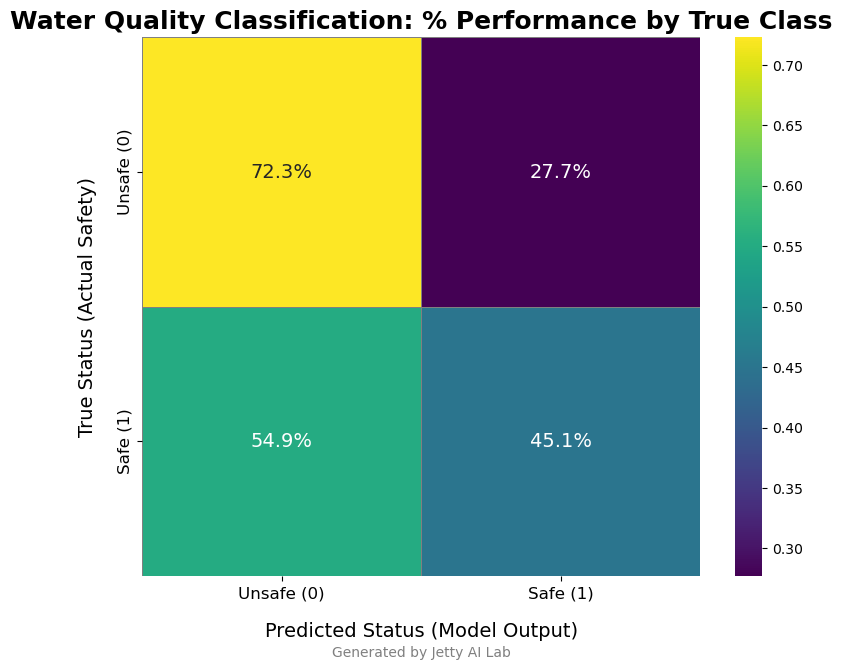

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import pandas as pd
import numpy as np

# --- Assume y_test and y_pred are defined from your previous cells ---

# 1. Calculate the raw Confusion Matrix
cm = confusion_matrix(y_test, y_pred) 

# 2. Normalize the Confusion Matrix to percentages
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # Normalize rows (True Labels)

# 3. Define the labels
class_names = ['Unsafe (0)', 'Safe (1)'] 

# 4. Create a DataFrame for a clean Seaborn plot
df_cm_norm = pd.DataFrame(cm_norm, index=class_names, columns=class_names)

# 5. Plot the heatmap
plt.figure(figsize=(9, 7))
sns.heatmap(df_cm_norm, 
            annot=True, # Display numbers in the cells
            fmt='.1%', # Format as percentage with 1 decimal place
            cmap='viridis', # A different, modern colormap
            cbar=True, # Show color bar for percentages
            linewidths=0.7, 
            linecolor='grey',
            annot_kws={"size": 14})

# 6. Add enhanced titles and labels
plt.title('Water Quality Classification: % Performance by True Class', fontsize=18, fontweight='bold')
plt.ylabel('True Status (Actual Safety)', fontsize=14, labelpad=15)
plt.xlabel('Predicted Status (Model Output)', fontsize=14, labelpad=15)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.text(0.5, -0.15, 'Generated by Jetty AI Lab', horizontalalignment='center', 
         fontsize=10, color='gray', transform=plt.gca().transAxes)

# Save the high-resolution image
plt.savefig('water_quality_cm_percentages.png', dpi=300, bbox_inches='tight')
plt.show()